In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/bankrupt.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


# EDA

In [3]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [4]:
print("null of dataset")
print(df.isnull().values.any())
print("Sum Duplicate of dataset")
df[df.duplicated()]

null of dataset
False
Sum Duplicate of dataset


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability


In [5]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

Text(0.5, 1.0, 'Bankrupt?')

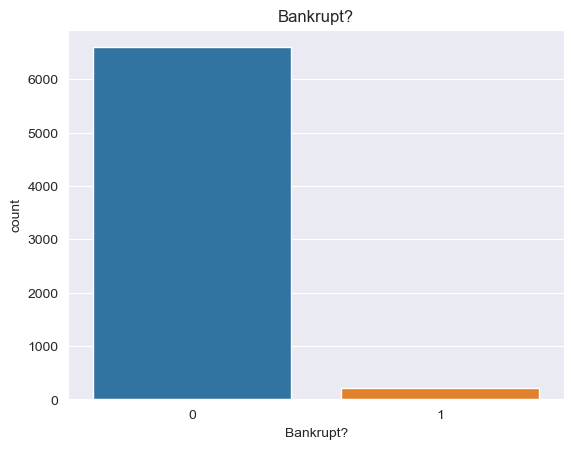

In [6]:
sns.countplot(x = df['Bankrupt?'])
plt.title('Bankrupt?')

## Data Preprocessing

In [6]:
X = df.drop('Bankrupt?', axis=1).reset_index(drop=True)
y = df['Bankrupt?'].reset_index(drop=True)

In [7]:
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, y.ravel())

df = X_smote
df['Bankrupt'] = y_smote

In [8]:
df['Bankrupt'].value_counts()

1    6599
0    6599
Name: Bankrupt, dtype: int64

In [9]:
print("Sum null of dataset")
print(df.isnull().values.any())
print("Sum Duplicate of dataset")
df[df.duplicated()]

Sum null of dataset
False
Sum Duplicate of dataset


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt


<AxesSubplot:>

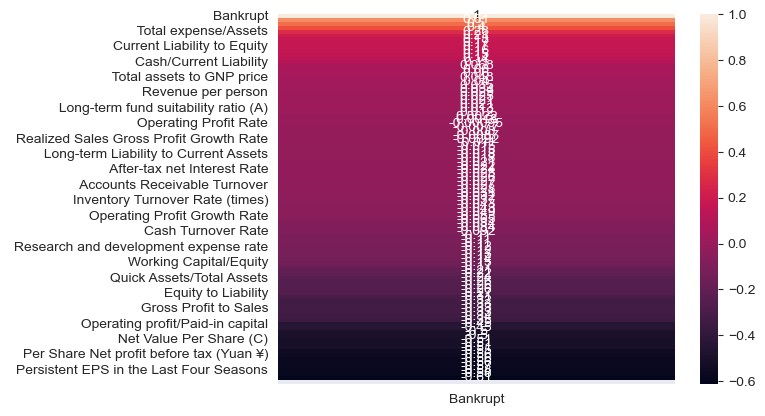

In [10]:
corr = df.corr()[['Bankrupt']].sort_values(by='Bankrupt', ascending=False)
sns.heatmap(corr, annot=True)

In [11]:
for i in df.columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df[i] = np.where(df[i] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR), df[i])
    df[i] = np.where(df[i] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR), df[i])

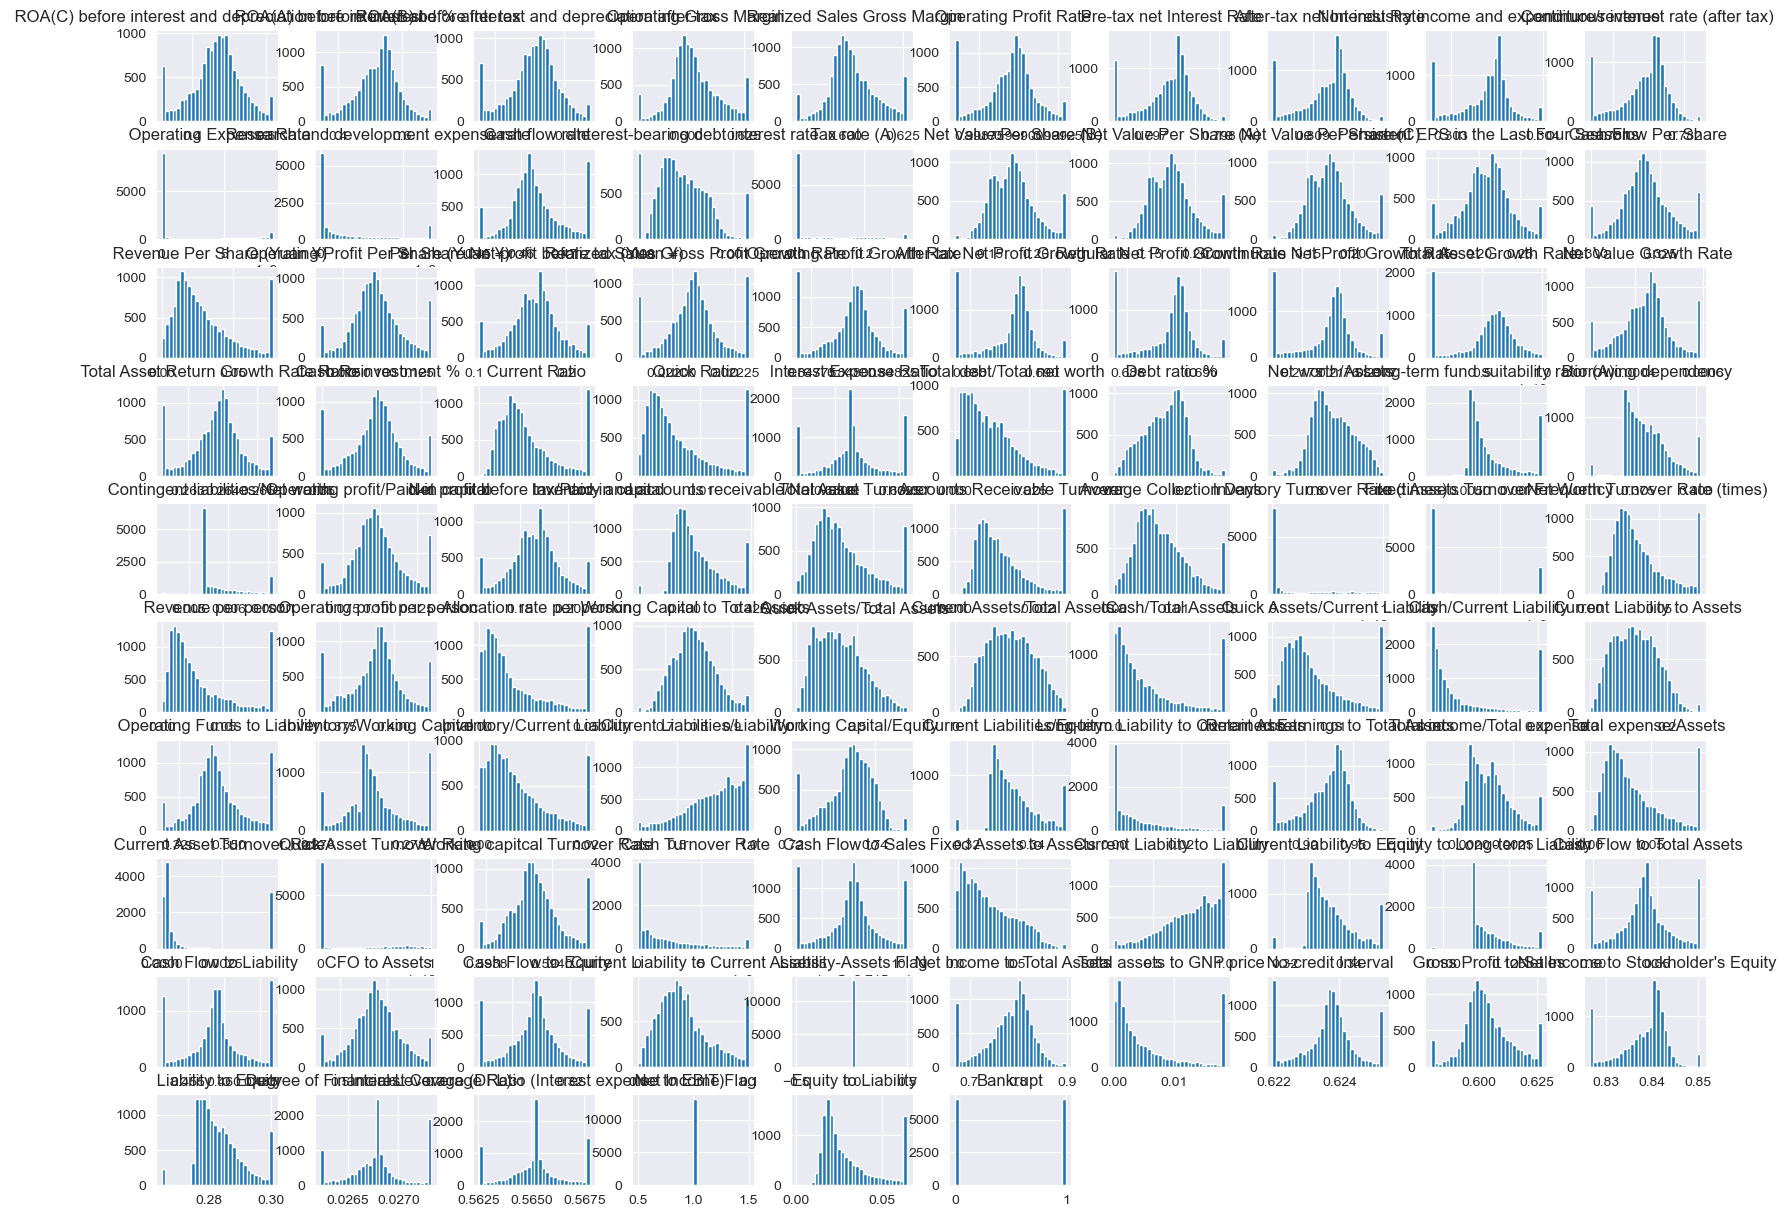

In [12]:
df.hist(bins=30, figsize=(20, 15))
plt.show()

In [13]:
X = df.drop('Bankrupt', axis=1).reset_index(drop=True)
y = df['Bankrupt'].reset_index(drop=True)

In [14]:
tf = StandardScaler().fit_transform(X)
scaledf = pd.DataFrame(tf, columns=X.columns)
scaledf['Bankrupt'] = y
scaledf

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt
0,-1.425268,-1.181554,-1.517766,-0.181127,-0.183119,0.178643,-0.986022,-1.070578,-2.071706,-1.254340,...,0.598578,-0.857329,-0.181331,-1.872234,0.950210,-0.647583,-0.805226,0.0,-0.852887,1.0
1,-0.018161,0.310012,0.063917,0.666008,0.667601,0.037937,0.374525,0.393942,0.650602,0.253420,...,0.446927,0.031450,0.666224,0.363986,0.065721,1.748530,1.803681,0.0,-0.579804,1.0
2,-0.592131,-0.203607,-0.569366,-0.181822,-0.192199,-0.498986,-2.160981,-2.149019,-2.071706,-2.175284,...,2.122758,0.249160,-0.181713,-0.227504,0.948351,-0.798723,-1.047081,0.0,-0.852547,1.0
3,-0.986004,-0.829379,-0.776900,-1.910172,-1.919482,-1.453827,-0.765754,-0.604912,-0.071899,-0.513252,...,-0.411194,-0.800111,-1.910140,-0.612060,-0.229965,-0.331537,-0.374073,0.0,-0.378536,1.0
4,-0.007179,0.312869,0.143269,-0.439162,-0.442246,0.202444,0.335586,0.402868,0.366159,0.380928,...,-0.305412,-0.119264,-0.439150,0.364629,-0.676307,-1.888714,1.803681,0.0,0.347982,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,-2.203874,-1.762560,-1.698342,0.961730,0.977206,-1.049804,-0.576955,-0.501273,-0.141606,-0.464091,...,0.092641,0.516496,0.961445,-1.178356,-0.503585,-0.230616,-0.282966,0.0,0.118916,1.0
13194,-2.205590,-2.138438,-2.252219,-0.554442,-0.555603,0.269619,-0.083879,-0.067454,-0.642161,-0.064977,...,-0.466230,-0.334164,-0.554446,2.321734,-2.580281,-0.053866,-0.073217,0.0,-1.205089,1.0
13195,-1.803189,-1.540581,-1.755584,-0.212231,-0.214354,-0.181662,-0.702411,-0.620869,-1.465731,-0.707475,...,-0.760405,-0.303888,-0.212183,-2.162539,2.382293,-0.243672,-0.276756,0.0,-0.730586,1.0
13196,0.053154,0.039688,0.189193,0.856996,0.859397,0.261998,-0.333665,-0.209551,-1.185363,-0.165795,...,-0.822098,0.237283,0.856754,0.171273,0.219364,1.748530,1.523834,0.0,-0.641851,1.0


In [15]:
print(scaledf.isnull().values.any())
scaledf.describe()

False


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt
count,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,...,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,1.319800e+04,13198.0,1.319800e+04,13198.000000
mean,1.945540e-16,4.210177e-15,-3.023713e-17,2.968101e-15,-3.534140e-15,-5.983320e-13,-1.516070e-13,5.029208e-14,-1.334484e-13,-2.905430e-14,...,1.012403e-15,1.299247e-13,-1.326741e-15,2.814436e-14,8.515402e-16,-6.336128e-15,3.109617e-15,0.0,4.578774e-15,0.500000
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,...,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,0.0,1.000038e+00,0.500019
min,-2.236411e+00,-2.252979e+00,-2.252219e+00,-2.337351e+00,-2.333271e+00,-2.083555e+00,-2.160981e+00,-2.149019e+00,-2.071706e+00,-2.175284e+00,...,-9.616011e-01,-1.911162e+00,-2.337733e+00,-2.162539e+00,-2.580281e+00,-1.888714e+00,-1.873679e+00,0.0,-1.892596e+00,0.000000
25%,-5.332942e-01,-5.278813e-01,-5.324665e-01,-6.037506e-01,-6.014521e-01,-4.816200e-01,-4.811764e-01,-4.709690e-01,-4.813674e-01,-4.817255e-01,...,-7.586264e-01,-4.596521e-01,-6.038078e-01,-4.809368e-01,-7.193161e-01,-5.247473e-01,-4.946689e-01,0.0,-7.356021e-01,0.000000
50%,5.995723e-02,1.578551e-01,1.027173e-01,-1.428737e-01,-1.443158e-01,1.715320e-01,2.538960e-01,2.892297e-01,2.640782e-01,2.640158e-01,...,-4.311199e-01,1.126901e-01,-1.426809e-01,3.058625e-01,-1.933327e-01,-2.036461e-02,-2.132983e-02,0.0,-3.990326e-01,0.500000
75%,6.021167e-01,6.221837e-01,6.140351e-01,5.519828e-01,5.530936e-01,5.863364e-01,6.386936e-01,6.477306e-01,5.788585e-01,6.473136e-01,...,3.939273e-01,5.080213e-01,5.521422e-01,6.401313e-01,5.213273e-01,3.845637e-01,4.246710e-01,0.0,4.285969e-01,1.000000
max,2.305233e+00,2.347281e+00,2.333787e+00,2.285583e+00,2.284912e+00,2.188271e+00,2.318499e+00,2.325780e+00,2.169197e+00,2.340872e+00,...,2.122758e+00,1.959531e+00,2.286067e+00,2.321734e+00,2.382293e+00,1.748530e+00,1.803681e+00,0.0,2.174896e+00,1.000000


In [16]:
xx = scaledf.drop('Bankrupt', axis=1)
yy = scaledf['Bankrupt']
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10558, 95) (10558,) (2640, 95) (2640,)


In [17]:
x_val = X_train[-2640:]
y_val = y_train[-2640:]

## Modelling

In [18]:
model = keras.Sequential([
    layers.BatchNormalization(input_dim=95),
    layers.Dense(95, activation='relu', input_dim=95),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(2, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 95)               380       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 95)                9120      
                                                                 
 batch_normalization_1 (Batc  (None, 95)               380       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 192       
                                                                 
 batch_normalization_2 (Batc  (None, 2)                8

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
history = model.fit(
    X_train,
    y_train,
    batch_size=30,
    epochs=50,
    validation_data=(x_val, y_val),
)

Epoch 1/50
352/352 [==============================] - 7s 8ms/step - loss: 0.3428 - accuracy: 0.8660 - val_loss: 0.2001 - val_accuracy: 0.9451
Epoch 2/50
352/352 [==============================] - 2s 6ms/step - loss: 0.2333 - accuracy: 0.9200 - val_loss: 0.1217 - val_accuracy: 0.9591
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1877 - accuracy: 0.9370 - val_loss: 0.0978 - val_accuracy: 0.9742
Epoch 4/50
352/352 [==============================] - 2s 7ms/step - loss: 0.1730 - accuracy: 0.9390 - val_loss: 0.0716 - val_accuracy: 0.9807
Epoch 5/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1522 - accuracy: 0.9449 - val_loss: 0.0541 - val_accuracy: 0.9848
Epoch 6/50
352/352 [==============================] - 2s 6ms/step - loss: 0.1297 - accuracy: 0.9527 - val_loss: 0.0470 - val_accuracy: 0.9879
Epoch 7/50
352/352 [==============================] - 2s 7ms/step - loss: 0.1310 - accuracy: 0.9507 - val_loss: 0.0407 - val_accuracy: 0.9867
Epoch 

## Model Evaluation

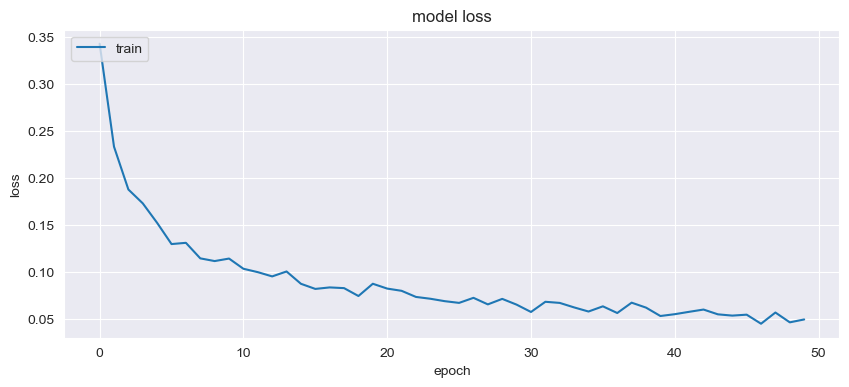

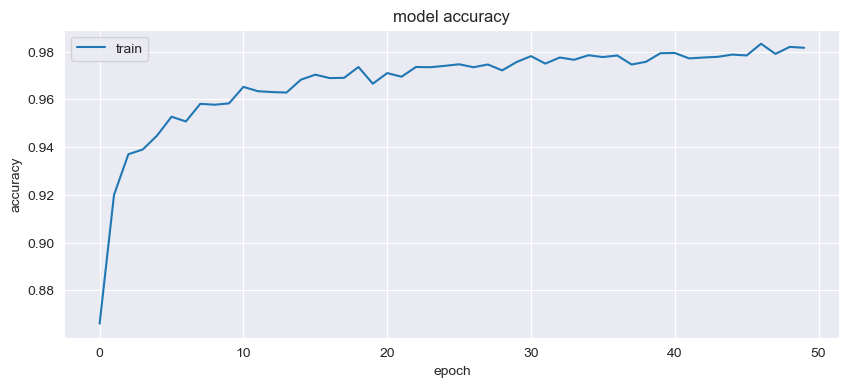

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [26]:
kelas = np.round(model.predict(X_test), 0)
hasil_prediksi = np.asarray(kelas, dtype='int')
print(hasil_prediksi)
ypred = hasil_prediksi

83/83 [==============================] - 1s 3ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


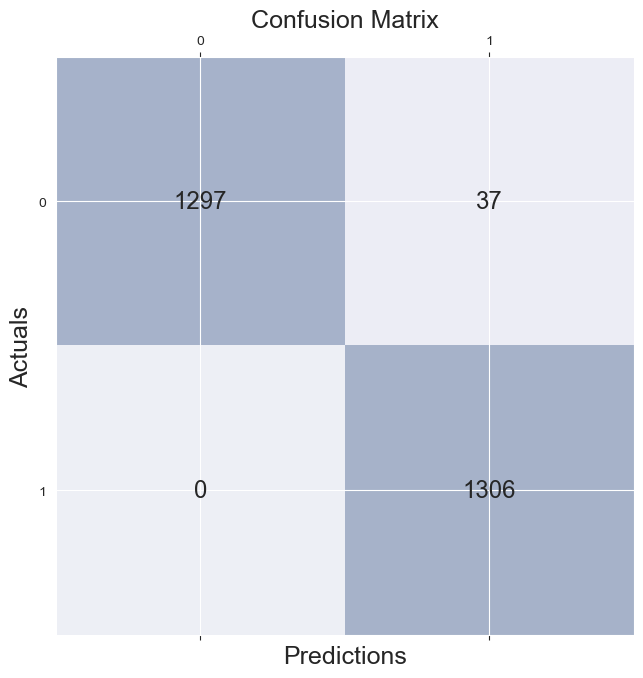

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1297
           1       1.00      0.97      0.99      1343

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640



In [27]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
report = classification_report(ypred, y_test)
print(report)